### Libraries

In [1]:
import glob
import os
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
import texthero as hero
from texthero import preprocessing
sb.set() # set the default Seaborn style for graphics

### Chunking CSV to upload onto GitHub

import pandas as pd

chunk_size = 55000
batch_no = 1

for chunk in pd.read_csv('221100_DayZ.csv', chunksize=chunk_size):
    #chunk.to_csv('221100_DayZ' + str(batch_no) + '.csv', index=False)
    #batch_no +=1

### Dataset

In [2]:
steamData = pd.read_csv('steam_data/steam.csv')
steamSupportInfo = pd.read_csv('steam_data/steam_support_info.csv')
steamChart = pd.read_csv('steam_data/steamCharts.csv')
steamSpyTagData = pd.read_csv('steam_data/steamspy_tag_data.csv')
steamGames = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "steam_data/steam_games/steam_games*.csv"))))
steamMediaData = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "steam_data/steam_media_data/steam_media_data*.csv"))))
steamRequirements = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "steam_data/steam_requirements/steam_requirements*.csv"))))
steamDescription = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "steam_data/steam_description/steam_description*.csv"))))

#game reviews
steam_HalfOfTheGameReviews = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "steam_data/steam_reviews/steam_review_*.csv"))))
files = glob.glob("steam_data/steam_reviews" + '**/**' + "/*.csv")
steamReviews_fromFolder = pd.concat([pd.read_csv(f) for f in files ])
steamReviewsDF = [steam_HalfOfTheGameReviews, steamReviews_fromFolder]
steamCombinedReviews = pd.concat(steamReviewsDF)

C:\Users\Pyae Pyae\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (23) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\Pyae Pyae\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (1,23) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\Pyae Pyae\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
C:\Users\Pyae Pyae\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (23) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


### Cleaning the Dataset

In [3]:
#rename for easier identification
steamGames = steamGames.rename(columns={"name": "title"})

#create a custom cleaning pipeline
custom_pipeline = [preprocessing.fillna
                   , preprocessing.lowercase
                   , preprocessing.remove_punctuation
                   , preprocessing.remove_diacritics
                   , preprocessing.remove_whitespace]

steamCombinedReviews['title'] = hero.clean(steamCombinedReviews['title'], pipeline = custom_pipeline)
steamGames['title'] = hero.clean(steamGames['title'], pipeline = custom_pipeline)

##### Getting title and genre

In [4]:
#getting title and genre from steamGames df
steamGames_Title_Genre = steamGames[['title', 'genre']]

#getting title and review from steamCombinedReviews df
steamCombinedReviews_Title_Reviews = steamCombinedReviews[['title', 'review']]

##### matching title in steamGames with steamCombinedReview

In [5]:
matchTitle = steamGames_Title_Genre.title.isin(steamCombinedReviews_Title_Reviews.title)
#matchTitle = steamCombinedReviews.title.isin(steamGames.title)
#matchTitle
steamMatchTitle = steamGames_Title_Genre[matchTitle]

##### dropping duplicate values

In [6]:
steamUniqueTitle = steamMatchTitle.drop_duplicates(['title'])
steamUniqueTitle

,title,genre
1,playerunknown s battlegrounds,"Action,Adventure,Massively Multiplayer"
2,battletech,"Action,Adventure,Strategy"
7,human fall flat,"Adventure,Indie"
8,they are billions,"Strategy,Early Access"
42,counter strike source,Action
...,...,...
1596,atlas,"Action,Adventure,Massively Multiplayer,RPG,Ear..."
1971,metro exodus,Action
9343,transport fever 2,"Simulation,Strategy"
9790,halo the master chief collection,Action


##### Remove Early Acess, Massively Multiplayer and Free to Play values

In [9]:
steamUniqueTitle['genre'] = steamUniqueTitle.genre.str.replace(',Early Access?' , '')
steamUniqueTitle['genre'] = steamUniqueTitle.genre.str.replace(',Massively Multiplayer?' , '')
steamUniqueTitle['genre'] = steamUniqueTitle.genre.str.replace(',Free to Play?' , '')

<ipython-input-9-c5996133bd8b>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  steamUniqueTitle['genre'] = steamUniqueTitle.genre.str.replace(',Early Access?' , '')
<ipython-input-9-c5996133bd8b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  steamUniqueTitle['genre'] = steamUniqueTitle.genre.str.replace(',Early Access?' , '')
<ipython-input-9-c5996133bd8b>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  steamUniqueTitle['genre'] = steamUniqueTitle.genre.str.replace(',Massively Multiplayer?' , '')
<ipython-input-9-c5996133bd8b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

##### split genre into 6 columns

In [10]:
steamUniqueTitle[['genre1', 'genre2', 'genre3','genre4','genre5','genre6']] = steamUniqueTitle['genre'].str.split(',', expand=True)

C:\Users\Pyae Pyae\anaconda3\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [11]:
steamUniqueTitle

,title,genre,genre1,genre2,genre3,genre4,genre5,genre6
1,playerunknown s battlegrounds,"Action,Adventure",Action,Adventure,None,None,None,None
2,battletech,"Action,Adventure,Strategy",Action,Adventure,Strategy,None,None,None
7,human fall flat,"Adventure,Indie",Adventure,Indie,None,None,None,None
8,they are billions,Strategy,Strategy,None,None,None,None,None
42,counter strike source,Action,Action,None,None,None,None,None
...,...,...,...,...,...,...,...,...
1596,atlas,"Action,Adventure,RPG",Action,Adventure,RPG,None,None,None
1971,metro exodus,Action,Action,None,None,None,None,None
9343,transport fever 2,"Simulation,Strategy",Simulation,Strategy,None,None,None,None
9790,halo the master chief collection,Action,Action,None,None,None,None,None


In [25]:
steamGenreCount = steamUniqueTitle.drop(columns=['genre','title'])

In [54]:
df = steamGenreCount.stack().value_counts().reset_index()

In [63]:
df.columns = ['genre','count']

<AxesSubplot:xlabel='genre', ylabel='count'>

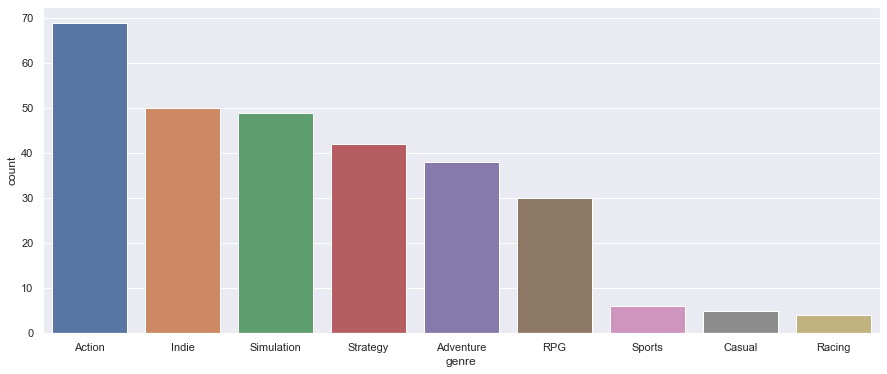

In [83]:
fig_dims = (15, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sb.barplot(x="genre", y="count", data=df, ax=ax)

In [ ]:
#steamUniqueTitle.to_excel("output.xlsx")  